In [1]:
def cols(d):
    print(list(d.columns))

trans_yr = {'平成21年':2009,
            '平成22年':2010,
            '平成23年':2011,
            '平成24年':2012,
            '平成25年':2013,
            '平成26年':2014,
            '平成27年':2015,
            '平成28年':2016,
            '平成29年':2017,
            '平成30年':2018,
            '平成31年':2019,
            '令和2年':2020,
            '令和3年':2021,
            '令和4年':2022}

import os 

data_dir = os.getcwd()+'/../data'
data_dir

'/Users/mori/Documents/Devel/Tokyo_Ward_Assembly_Election/jupyter/../data'

In [2]:
def get_birth(ystr, option):
    # ystr = 09~22 : string
    # option = 1300, 1310, 1510 : string
    j = pd.read_excel(data_dir+"/ju"+ystr+"qa"+option+".xls",header=1)#, engine='openpyxl')
    tmp = pd.DataFrame(j.iloc[9:83,[1,14]])
    tmp.columns = ['ward', 'birth_num']
    tmp['year'] = int(ystr)+2000
    tmp.iloc[0,0]='区部'
    tmp.iloc[24,0]='市部'
    tmp.iloc[51,0]='町村部'
    tmp.iloc[52,0]='郡部'
    tmp.iloc[57,0]='島嶼部'
    tmp['birth_num'] = tmp['birth_num'].astype('int')
    return tmp.dropna()

import pandas as pd

birth_stat = pd.DataFrame()

for y in list(range(2009,2013)):
    ystr = str(y).replace('20','')
    birth_stat = pd.concat([birth_stat, get_birth(ystr, "1300")])

birth_stat = pd.concat([birth_stat, get_birth('13', "1310")])

for y in list(range(14,22)):
    birth_stat = pd.concat([birth_stat, get_birth(str(y), "1510")])

In [3]:
def ty (x):
    return trans_yr[x]

files = ["人口推移年少.csv","人口推移生産.csv","人口推移老年.csv"]

ward_pop = {} #pd.DataFrame()

ward_stat = pd.DataFrame()

for f in files:
    
    fname = f.replace('.csv','')
    dd = pd.read_csv(data_dir + '/' + f, encoding = "shift-jis", header=6)

    clm = pd.DataFrame(dd.columns)

    yuko=[2,3]+list(range(76,148,1))

    ddd=dd.iloc[:,yuko].set_index(['地域コード','地域'])
    data = pd.DataFrame(ddd.stack().reset_index(drop=False))

    filters = (data['level_2'].str.contains('総数')) & ~(data['level_2'].str.contains('再掲'))
    pdata = data[filters].rename(columns={'level_2':'year', 0:'人口'})

    pdata['年'] = pdata['year'].str.replace('／人口総計','',regex=True).str.replace('／総数\(人\)','',regex=True)
    #pdata['年'] = pdata['year'].str.replace('／総数\(人\)','')
    pdata['year'] = pdata['年'].apply(ty)
    pdata['地域コード'] = pdata['地域コード'].astype('int')
    pdata['人口'] = pdata['人口'].astype('int')
    pdata['tier'] = fname
    
    pdata.drop(columns=['year']).to_excel(data_dir+'/'+fname+'.xlsx', index=False)

    ward_pop[fname]=pdata
    
    ward_stat = pd.concat([ward_stat, pdata.drop(columns='地域コード')])

In [4]:
tokyocode = pd.read_csv('../data/tokyo_code.csv').rename(columns={'団体コード':'地域コード','団体名':'地域'})

In [5]:
bd=pd.merge(tokyocode, birth_stat, right_on='ward', left_on='地域')
wd=pd.merge(tokyocode, ward_stat, on='地域')

### n+1年の15歳人口

年少とは0〜14歳

[n年の年少人口]+[n+1年の出生数] = [n+1年の年少人口]+[n+1年の15歳人口] 

[n+1年の15歳人口]　= [n年の年少人口] + [n+1年の出生数] - [n+1年の年少人口]
        A        =       x       +       y       -       z



In [6]:
# wdは区ごとの各年の3層人口データ
wd['pyear'] = wd['year']-1 # pyearは前年の年少人口を自分とmergeして追加する時に使う

wd_shrt_col = ['地域コード', '地域', 'year', 'pyear','tier','人口']

wd_short=wd[wd_shrt_col]

wyoung = wd_short[wd_short['tier']=='人口推移年少'].drop(columns=['tier'])
wmiddle = wd_short[wd_short['tier']=='人口推移生産'].drop(columns=['tier'])
wold = wd_short[wd_short['tier']=='人口推移老年'].drop(columns=['tier'])

# bdは出生数データ
bd_shrt_col = ['地域コード', '地域', 'year','birth_num']

bd_short=bd[bd_shrt_col]

In [7]:
#
# 年少人口_n+1と出生数_n+1
#
#

d15tmp = pd.merge(wyoung, bd_short, 
               left_on=['地域コード','地域','year'],
               right_on=['地域コード','地域','year'],
                 ).rename(columns={'year':'y_n+1',
                                   'pyear':'y_n',
                                   '人口':'人口_n+1', 'birth_num':'出生_n+1'}
                         )


d15 = pd.merge(d15tmp, wyoung,
                   left_on=['地域コード','地域','y_n+1'],
                   right_on=['地域コード','地域','pyear']
                  ).drop(columns=['year','pyear']
                    ).rename(columns={'人口':'人口_n'})

In [8]:
d15['15歳人口'] = d15['人口_n'] + d15['出生_n+1'] - d15['人口_n+1']

In [9]:
for i,z in d15.iterrows():
    d15.loc[i,'年齢'] = str(2036 - d15.loc[i,'y_n+1'])+'歳'
    d15.loc[i,'age'] = int(2036 - d15.loc[i,'y_n+1'])
    
d15['age']=d15['age'].astype(int)


In [10]:
nl = ['y_n+1', 'y_n', '人口_n+1', '出生_n+1', '人口_n']
wl = ['年','前年','人口','出生数','人口（前年）']
d15=d15.rename(columns=dict(zip(nl,wl)))

# ◇ 集計と可視化

In [11]:
#
# 区に限る
tokyocode = pd.read_csv('../data/tokyo_code.csv').rename(columns={'団体コード':'地域コード','団体名':'地域'})
sorted_wards = list(tokyocode[(131000 <tokyocode['地域コード']) & (tokyocode['地域コード']<132000)]['地域'])

def lim_ward(d):
    return d[(131000 <d['地域コード']) & (d['地域コード']<132000)]


### ＊各年の15歳人口

年少とは0〜14歳

[n年の年少人口]+[n+1年の出生数] = [n+1年の年少人口]+[n+1年の15歳人口] 

[n+1年の15歳人口]　= [n年の年少人口] + [n+1年の出生数] - [n+1年の年少人口]
        

```
for w in 市区町村:
    for y in 2010~2021:
        x = wd[(wd['地域']==w) & (wd['year']==y-1) & (wd['tier'] == '人口推移年少')].loc[]
```

In [12]:
print(list(d15.columns))

['地域コード', '地域', '年', '前年', '人口', '出生数', '人口（前年）', '15歳人口', '年齢', 'age']


## 統括データ result

In [15]:
younger=d15[['地域コード', '地域', '15歳人口', '年齢', 'age']].rename(columns={'15歳人口':'人口'})

wo=wold[(wold['year']==2021)]
wo=wo.drop(columns=['pyear']).rename(columns={'year':'年'})
wo['age']=65
wo['年齢']='65歳以上'
wo=wo.rename(columns={'65歳以上':'人口'})

result = pd.concat([wo, younger])


result.to_csv(data_dir + '/2021年区別年齢別人口分布.csv', index=False)
d15.to_csv(data_dir + '/2009-2021区別15歳人口推移.csv', index=False)

ここまでがクレンジング、resultデータフレームのファイルをresutl読み込んで以下をBIで実行。

### ＊老年の人口2021

In [16]:
import plotly.express as px

In [17]:
older_people =lim_ward(result[result['age']>64])

otext_data = list(older_people.groupby(['地域コード','地域']
                           ).sum('人口').reset_index().drop(columns='age').sort_values('地域コード')['人口'])

fig_old = px.bar(
    older_people,
    y='地域',
    x='人口',
    title='65歳以上人口',
    category_orders={'地域':sorted_wards},
    height=800,
    width=900,
    orientation='h',
    range_x=(0,200000)
)
fig_old.data[0].text = list(map((lambda x: '{:,d}'.format(x)), otext_data))
fig_old.data[0]['hovertemplate'] ='人口=%{x:,d}'+'<br>地域=%{y}'


### ＊18〜20代前半の区ごとの分布

In [18]:
younger_people = lim_ward(result[(result['age']>17)&(65>result['age'])])
text_data = list(younger_people.groupby(['地域コード','地域']
                                  ).sum('人口').reset_index().drop(columns='age').sort_values('地域コード')['人口'])

fig_young = px.bar(
    younger_people,
    x='人口',
    y='地域',
    title='18〜27歳人口（トップの数は和）',
    color='年齢',
    height=800,
    width=920,
    category_orders={'地域':sorted_wards},
    color_discrete_sequence = px.colors.sequential.dense_r,
    orientation='h',
    range_x=(0,200000),
)

fig_young.data[-1].text = list(map((lambda x: '{:,}'.format(x)), text_data))
#fig_young.update_traces(textposition='outside')

### ＊15歳人口の推移

In [24]:
fig_fifteen = px.line(
    lim_ward(d15).sort_values('年'),
    x='年',
    y='15歳人口',
    text='15歳人口',
    title='15歳人口の推移',
    color='地域',
    category_orders={'地域':sorted_wards,
                     'y_n+1':list(range(2009,2021,1))},
    markers=True,
    height=800,
    width=1000
)

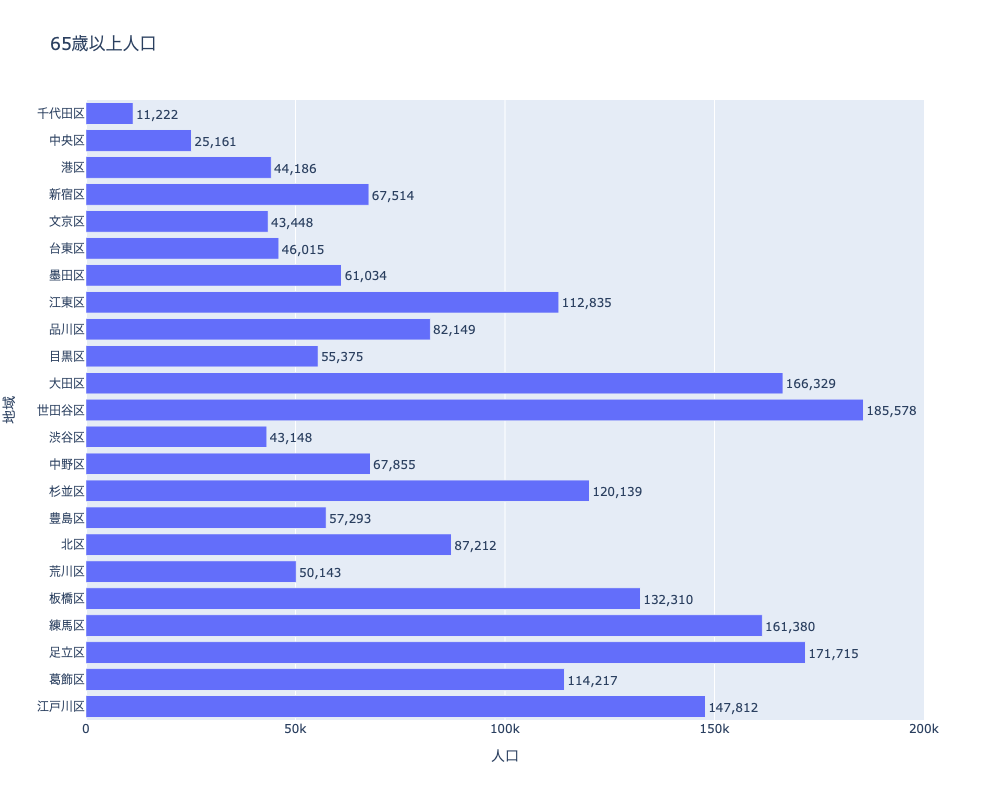

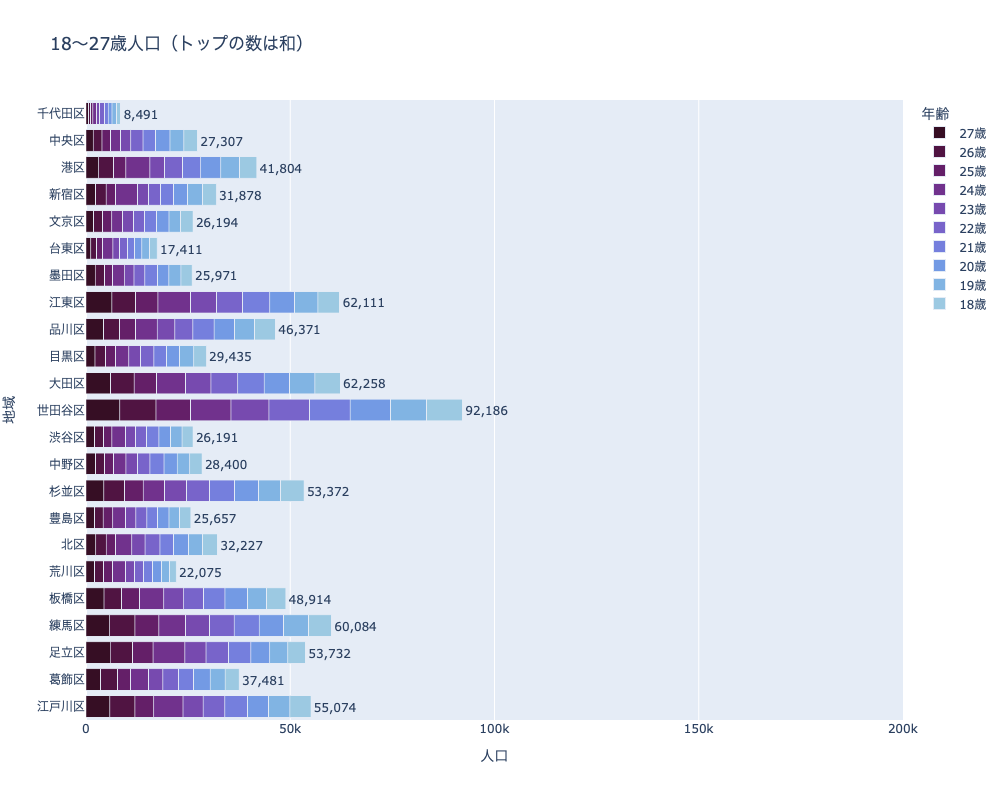

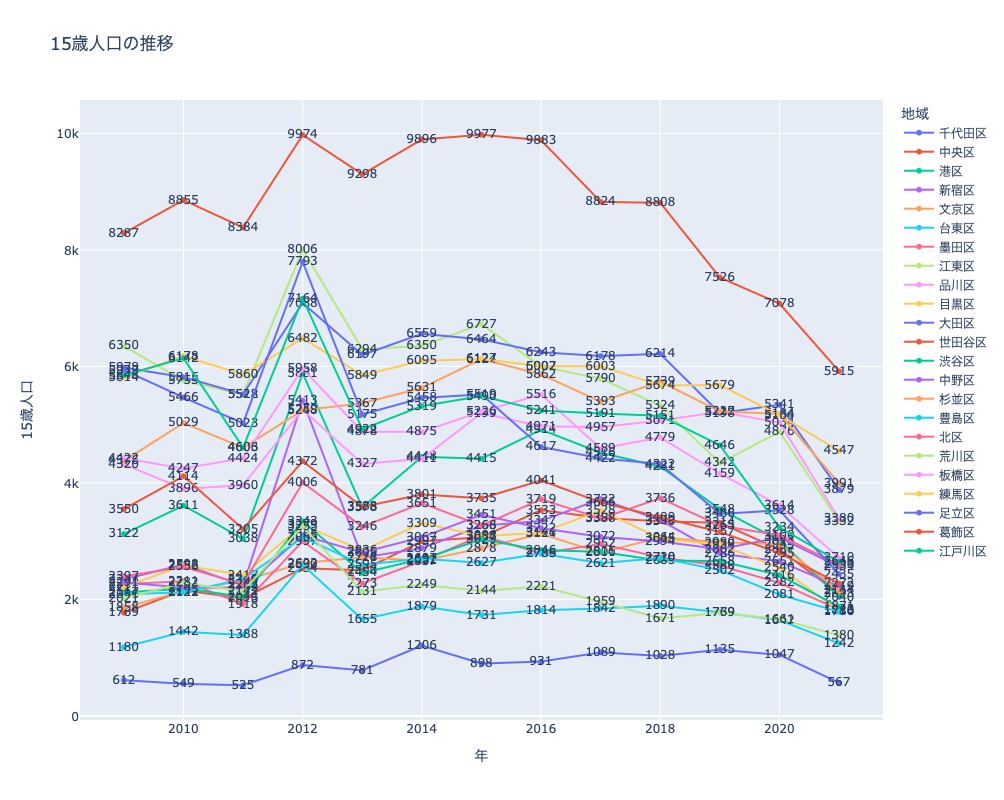

In [25]:
fig_old.update_traces(textposition='outside')
fig_old.show()
fig_young.update_traces(textposition='outside')
fig_young.show()

fig_fifteen.show()